In [190]:
"""
@authors: faurand, chardes, ehagensieker
"""
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import tqdm
import pprint

In [191]:
# add an empty dimension and scale the images to values between 0 and 1
normalize = lambda x: tf.cast(tf.expand_dims(x, -1), tf.float32) / 255.

# add noise to the image   
add_noise = lambda x, e: tf.clip_by_value(x + e * tf.random.normal(mean=0., stddev=1., shape=x.shape),
                                          clip_value_min=0.,
                                          clip_value_max=1.)

def prepare_data(ds, noise_level=0.4, batch_size=32):
    # apply lambda functions
    ds = ds.map(lambda x,t: (normalize(x), normalize(t)))
    ds = ds.map(lambda x,t: (add_noise(x, noise_level), t))
    
    # shuffle, batch, prefetch
    ds = ds.cache().shuffle(1028).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return ds

def plot_images(ds, img_size=(28,28)):
    fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(22,5))

    for noisy_images, original_images in ds.take(1):
        for i in range(10): 
            ax[0,i].imshow(noisy_images[i].numpy().reshape(img_size))
            ax[0,i].set(title='noisy image')
            ax[1,i].imshow(original_images[i].numpy().reshape(img_size))
            ax[1,i].set(title='original image')

    plt.show();

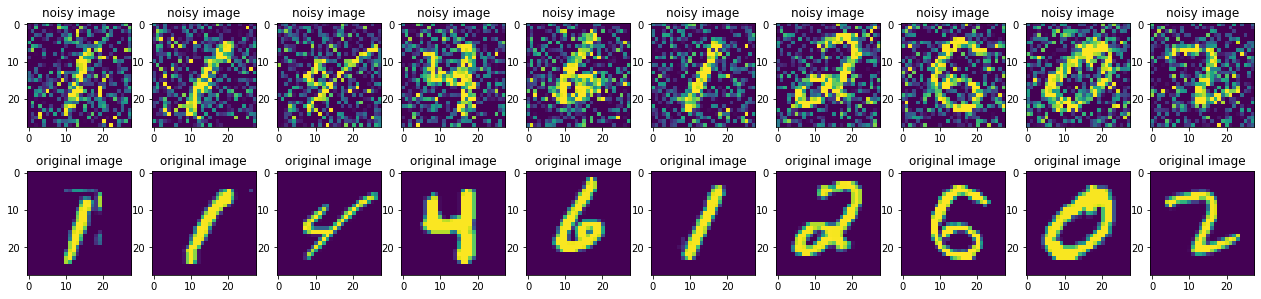

tf.Tensor([32 28 28  1], shape=(4,), dtype=int32)
tf.Tensor([32 28 28  1], shape=(4,), dtype=int32)


In [192]:
# load the dataset
(X_train,_), (X_test,_) = tf.keras.datasets.mnist.load_data()

# set the originial images as targets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, X_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, X_test))

# prepare the dataset
train_ds = prepare_data(train_ds)
test_ds = prepare_data(test_ds)

# plot the noisy images and the original target images
plot_images(train_ds)

for e in train_ds.take(1): 
  print(tf.shape(e[0]))
  print(tf.shape(e[1]))

In [193]:
from tensorflow.python.ops.math_ops import xlog1py_eager_fallback
from keras.layers import Input, Conv2D, MaxPool2D, Dense, UpSampling2D, BatchNormalization

class Encoder(tf.keras.layers.Layer):

  '''
  create a small network with 2 blocks each having 2 layers and starting with 32 filters in the first layer
  '''
  def __init__(self, dimension_inter):
    super(Encoder, self).__init__()

    self.metrics_list = [tf.keras.metrics.Mean(name = "loss"),
                         tf.keras.metrics.CategoricalAccuracy(name = "acc")]

    # Encoder: The encoder should reduce the size of feature maps like a CNN78
# At the end of the encoder, flatten the feature maps and use a dense layer
# to produce an embedding of a certain siz

    input_shape = (28,28,3)

    self.layer_list = [tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = input_shape), 
                      
                       tf.keras.layers.Conv2D(filters = 32,kernel_size = 3, padding = 'same', activation = 'relu'), 
                       tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2), 

                       tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'), 
                       tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'), 
                       tf.keras.layers.GlobalAveragePooling2D(),
                       tf.keras.layers.Dense(units = 10, activation = "sigmoid")
    ]
  
  def call(self, x):
    for layer in self.layer_list[:-1]: 
      x = layer(x)
    return self.layer_list[-1](x)

In [194]:
from tensorflow.keras.layers import Dense

class Decoder(tf.keras.Model):
  '''
  create a small network with 2 blocks each having 2 layers and starting with 32 filters in the first layer
  '''
  def __init__(self, dimension_inter, dimension_orig):
    super(Decoder, self).__init__()

    self.loss_function = tf.keras.losses.CategoricalCrossentropy()

    self.metrics_list = [tf.keras.metrics.Mean(name = "loss"),
                         tf.keras.metrics.CategoricalAccuracy(name = "acc")]

    self.layer_list = [tf.keras.layers.Dense(units = dimension_inter, activation = 'relu'), 
                       tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, padding = 'valid', activation = 'relu'), 
                       tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, padding = 'valid', activation = 'relu'), 
                       tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size = 3, padding = "valid", activation = "sigmoid")
    ]
  
  def call(self, x):
    for layer in self.layer_list[:-1]: 
      x = layer(x)
    return self.layer_list[-1](x)


In [195]:
from keras.layers import Input, Conv2D, MaxPool2D, Dense, UpSampling2D, BatchNormalization

class Autoencoder(tf.keras.Model):
  '''
  create a small network with 2 blocks each having 2 layers and starting with 32 filters in the first layer
  '''
  def __init__(self, dimension_inter, dimension_orig, optimizer):
    super(Autoencoder, self).__init__()

    self.optimizer = optimizer
    self.loss_function = tf.keras.losses.CategoricalCrossentropy()

    self.metrics_list = [tf.keras.metrics.Mean(name = "loss"),
                         tf.keras.metrics.CategoricalAccuracy(name = "acc")]

    self.encoder = Encoder(dimension_inter=dimension_inter)
    self.decoder = Decoder(dimension_inter=dimension_inter, dimension_orig=dimension_orig)

  
  def call(self, input_features):
    code = self.encoder(input_features)
    reconstructed = self.decoder(code)
    return reconstructed        

  @property
  def metrics(self):
    return self.metrics_list


  def reset_metrics(self):
    for metric in self.metrics: 
      metric.reset_states()

  @tf.function 
  def train(self, loss, data):
    x, t = data
  
    with tf.GradientTape() as tape:
      output = self(x, training = True)
      loss = self.compiled_loss(t, output, regularization_losses = self.losses)
      
    gradient_variables = tape.gradient(loss, self.trainable_variables)
    
    self.optimizer.apply_gradients(zip(gradient_variables, self.trainable_variables))
      #print(x.shape)

    self.metrics[0].update_state(loss)
    
    for metric in self.metrics[1:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}

  @tf.function
  def test_step(self, data):
    x, t = data

    output = self(x, training = False)
    loss = self.loss_function(t, output)

    self.metrics[0].update_state(loss)
    
    for metric in self.metrics[1:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}

In [196]:
def loss(model, original):
  reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(original), original)))
  return reconstruction_error

In [197]:
def training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer): 
    '''
    create the training loop where the model is trained on the train dataset and afterwards tested on the validation dataset
    '''
    hist = {"train_loss":[],"train_acc":[],"test_loss":[], "test_acc":[]}
    #iterate over given amount of epochs
    for epoch in range(epochs): 
        print(f"Epoch {epoch}: ")

        #train on all batches of the training data
        for data in tqdm.tqdm(train_ds, position = 0, leave = True):
            metrics = model.train_step(data)

            with train_summary_writer.as_default(): 
                for metric in model.metrics: 
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # print the metrics and add to history element
        for key, value in metrics.items():
            hist[f"train_{key}"].append(value.numpy())
            print(f"train_{key}: {value.numpy()}")

        #reset metric 
        model.reset_metrics()

        #evaluation on validation set
        for data in val_ds:
            metrics = model.test_step(data)

            with val_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # print the metrics and add to history element
        for key, value in metrics.items():
            hist[f"test_{key}"].append(value.numpy())
            print(f"test_{key}: {value.numpy()}")

         #reset metric
        model.reset_metric()
        print("\n")
    
    return hist


In [198]:
def create_summary_writers(config_name):
  '''
  create the summary writer to have access to the metrics of the model 
  '''
  current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

  train_log_path = f"logs/submission/{config_name}/{current_time}/train"
  val_log_path = f"logs/submission/{config_name}/{current_time}/val"

  # log writer
  train_summary_writer = tf.summary.create_file_writer(train_log_path)
  val_summary_writer = tf.summary.create_file_writer(val_log_path)
    
  return train_summary_writer, val_summary_writer

In [199]:
#@title Standardtext für Titel
def run(model,num_epochs=15,save=True,load=False,config_name = f'RUN'):
  '''
  run the model and specify the number of epochs, batch_size and prepare the training and testing data
  '''

  train = prepare_data(train_ds)
  test = prepare_data(test_ds)

  ### Hyperparameters
  num_epochs = num_epochs
  batch_size = 32

  
  train_summary_writer, val_summary_writer = create_summary_writers(config_name)


  if load:
    model.load_weights(f"saved_model_{config_name}");

  hist = training_loop(model,train,test,num_epochs,train_summary_writer, val_summary_writer)
  if save:
    model.save_weights(f"saved_model_{config_name}", save_format="tf")


  
    
  fig, ax = plt.subplots(1,2, figsize=(10,10))

  ax[0].plot(hist['train_acc'], label='train accuracy')
  ax[0].plot(hist['test_acc'], label='test accuracy')
  ax[0].legend()

  ax[1].plot(hist['train_loss'], label='train loss')
  ax[1].plot(hist['test_loss'], label='test loss')
  ax[1].legend();

In [200]:
from keras.models import Model

autoencoder = Autoencoder(dimension_inter=64,dimension_orig=784, optimizer = tf.keras.optimizers.Adam)

model = Model(autoencoder, name = "vae")
run(model)

ValueError: ignored